Neste notebook:
* Avaliação de usuários por bucket  
    * em média, e mediana, em quantos buckets os utilizadores estão.  
    * quantos usuários novos estão em cada bucket e quantos não ocorrem

Objetivo:
* explorar caracteristicas dos datasets que permitam
    * avaliar se o dataset é util para a análise  
    * escolher o número de buckets  

Vamos definir o numero de itens em cada bucket como 50k

In [1]:
import os
import sys
sys.path.append(os.path.abspath('') + '/..')

In [2]:
from data import ImplicitData
from recommenders_implicit import ISGD  # ISGD framework, BISGD,
from eval_implicit import EvaluateAndStore # EvaluateAndStore para guardar estados do modelo e holdouts, a avaliação prequencial de ratings implicitos é opcional, , EvalHoldout
from dataset_evaluation_utils import * #get_interactions_info, plot_interactions_per_month, plot_user_presence_distribution, plot_n_users_per_bucket, plot_bucket_size

from datetime import datetime, timedelta

import joblib
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')

___
# Palco Playlist

In [3]:
# importa dataset 'palco playlists'
data = pd.read_csv("../datasets/playlisted_tracks.tsv","\t")
dataset_name = 'PalcoPlaylists'
user_col = 'playlist_id'

In [4]:
# Necessary Preprocess - create date from timestamp
data['date'] = data['CreatedAt'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d') )
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['date'] = data[['year', 'month']].apply(lambda x: datetime.strptime( str(x[0])+'/'+str(x[1]), '%Y/%m' ) , axis=1)

In [5]:
# this lets me sample the first 10% of the dataset to avoid cold start.
# data.iloc[ :int( 0.1*data.shape[0] ) ]

## Evaluating Time defined Buckets 

How many interactions occur in each month?

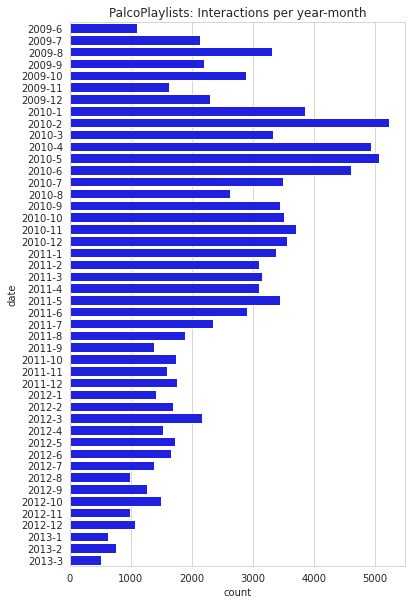

In [6]:
plot_interactions_per_month(data=data, dataset_name=dataset_name)

What is the user presence distribution based on month, quarter, and semester?

In [7]:
user_presence_df, user_month_interactions, trimestres, user_trimestre_interactions, semestres, user_semestre_interactions = get_interactions_info(data=data, user_col=user_col)

In [8]:
user_presence_df.head()

,UserID,month_%,trimestre_%,semestre_%
0,8258,0.608696,0.7500,0.750
1,15540,0.586957,0.8125,1.000
2,11141,0.543478,0.8125,0.875
3,23170,0.521739,0.7500,0.875
4,22172,0.521739,0.6875,0.750


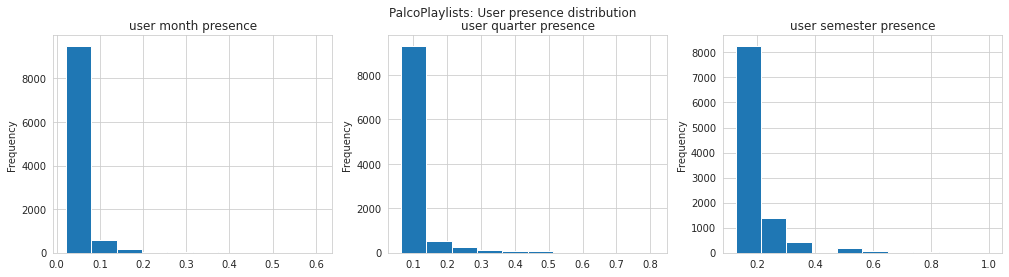

In [9]:
# plotting user frequency distribution
plot_user_presence_distribution(user_presence_df, dataset_name=dataset_name)

How many examples are there per quarter and semester?

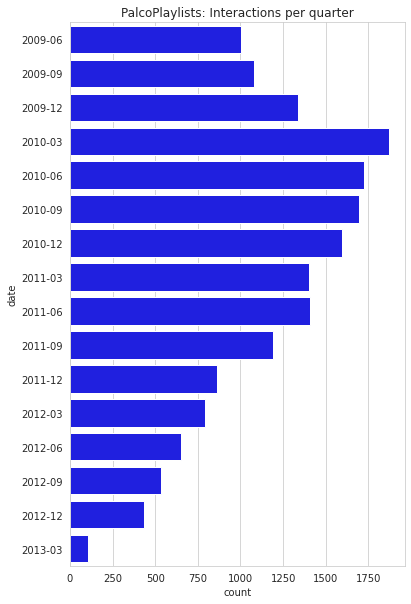

In [10]:
plot_interactions_per_qns(user_interactions=user_trimestre_interactions, date_range=trimestres, dataset_name=dataset_name, type_of_range='quarter')

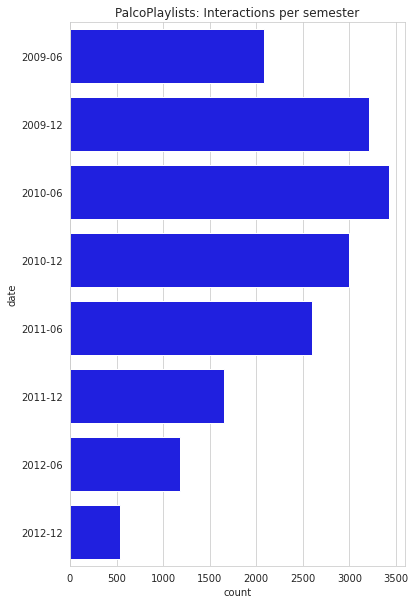

In [11]:
plot_interactions_per_qns(user_interactions=user_semestre_interactions, date_range=semestres, dataset_name=dataset_name, type_of_range='semester')

How many FREQUENT users (occur in 80% or more intervals) exist?

In [12]:
# defining threshold
frequency_threshold = 0.8

In [13]:
frequent_users_month, frequent_users_trimestre, frequent_users_semestre = get_frequent_users(user_presence_df, frequency_threshold=frequency_threshold)

0 users of 10392 (0.0%) occurr in 80.0% or more months.
2 users of 10392 (0.019%) occurr in 80.0% or more quarters.
13 users of 10392 (0.125%) occurr in 80.0% or more semesters.


In median terms, how many times FREQUENT users appear in each quarter, and semester?

In [14]:
freq_user_quarter_info = get_frequent_user_statistics(
    interactions_df=user_trimestre_interactions, frequent_users_list=frequent_users_trimestre)
# freq_user_quarter_info

<AxesSubplot:>

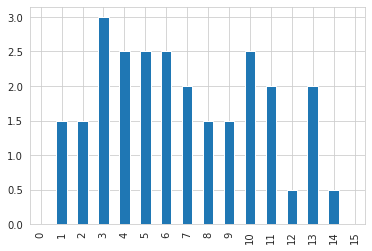

In [15]:
freq_user_quarter_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

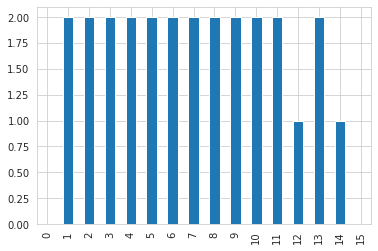

In [16]:
freq_user_quarter_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [17]:
# # frequent user interaction per quarter
# plot_interactions_per_qns(user_interactions=user_trimestre_interactions.loc[frequent_users_trimestre],
#     date_range=trimestres)

In [18]:
freq_user_semester_info = get_frequent_user_statistics(
    interactions_df=user_semestre_interactions, frequent_users_list=frequent_users_semestre)
# freq_user_semester_info

<AxesSubplot:>

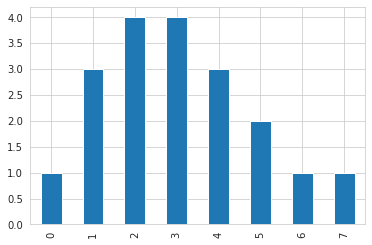

In [19]:
freq_user_semester_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

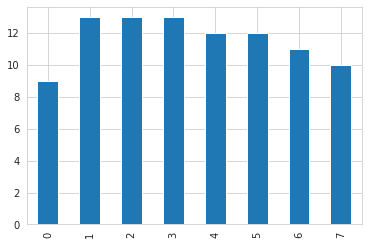

In [20]:
freq_user_semester_info['freq_users_at_least_1_interaction'].plot(kind='bar')

In [21]:
# plot_interactions_per_qns(user_interactions=user_semestre_interactions.loc[frequent_users_semestre], date_range=semestres, type_of_range='semester')

In [22]:
# these are the users that should be used in holdouts, and only their last interactions
# BUT, there are users that do not appear in some intervals, and some have only one interaction
user_trimestre_interactions.loc[frequent_users_trimestre]
user_semestre_interactions.loc[frequent_users_semestre];

## Evaluating Interactions 50E3 sized Buckets 

In [23]:
n_iter_bucket = 50E3

interval_start, interval_end = get_bucket_intervals(data, n_iter_bucket)    

How many users per bucket?    

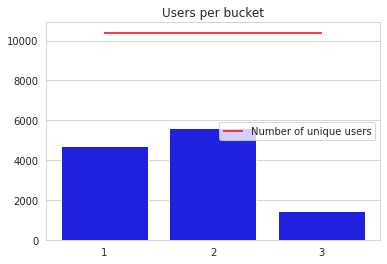

In [24]:
plot_users_per_fixed_bucket(data, user_col, interval_start, interval_end)

How many FREQUENT users (occur in 80% or more intervals) exist?

In [25]:
user_bucket_interactions_df, dates_fixed_buckets_df = get_fixed_buckets_info(data, user_col, interval_start, interval_end)

In [26]:
frequency_threshold = 0.8

In [27]:
frequent_users_bucket = get_frequent_users_fixed_buckets(user_bucket_interactions_df, frequency_threshold)

116 users of 10392 (1.116%) occur in 80.0% or more buckets.


In median terms, how many times FREQUENT users appear in each bucket?

In [28]:
freq_user_bucket_info = get_frequent_user_statistics(user_bucket_interactions_df, frequent_users_bucket)

<AxesSubplot:>

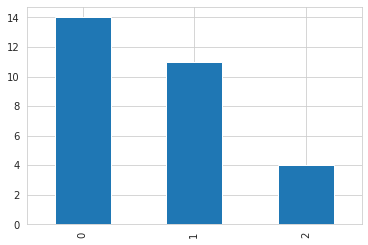

In [29]:
freq_user_bucket_info['median_freq_user_interactions'].plot(kind='bar')

<AxesSubplot:>

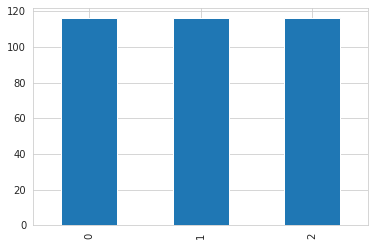

In [30]:
freq_user_bucket_info['freq_users_at_least_1_interaction'].plot(kind='bar')

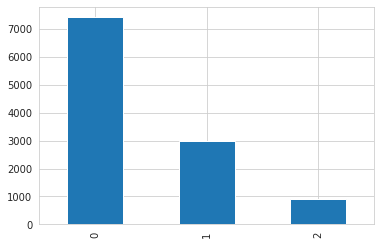

In [31]:
# frequent users interactions per bucket
plot_user_interactions_per_bucket(user_bucket_interactions_df, frequent_users_bucket)

Which timestamps occur in each bucket?

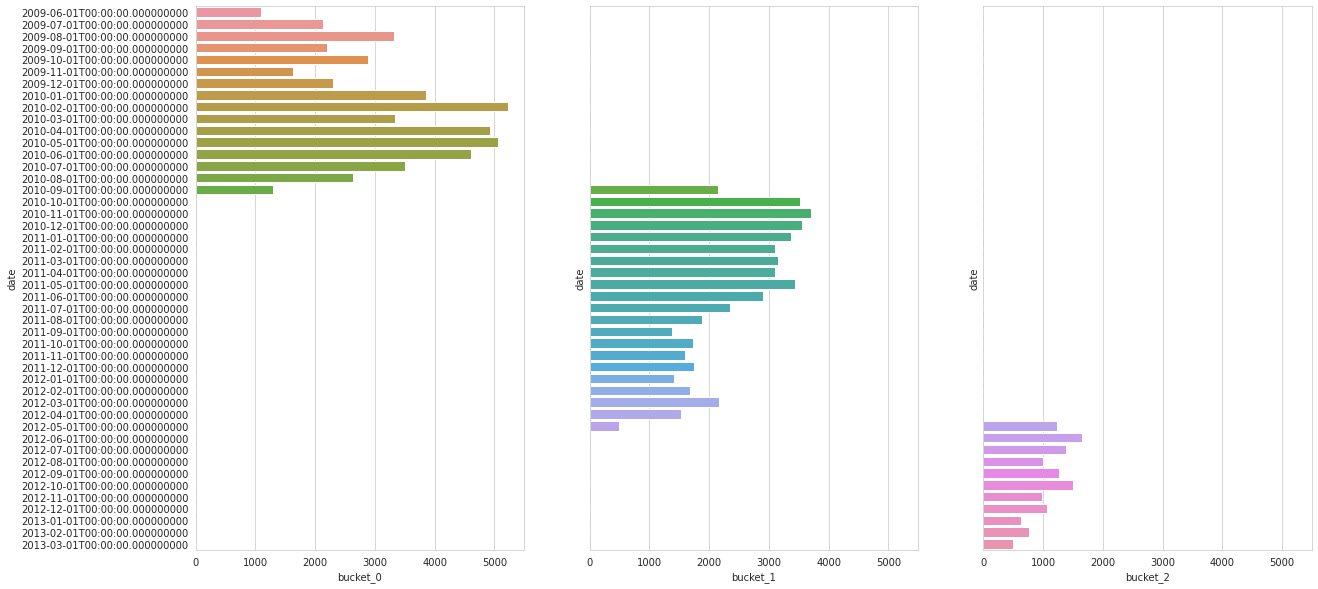

In [32]:
plot_timestamps_per_bucket(dates_fixed_buckets_df)